# TP3

<div style="text-align: right"> 
Grupo 2
</div>
<div style="text-align: right"> 
Javier Aguirre
</div>
<div style="text-align: right">     
Jonatan Bournissent
</div>
<div style="text-align: right">     
Fábio Negreiros Ribeiro
</div>
<div style="text-align: right">     
Jimena Olmos Asar
</div>
<div style="text-align: right">     
Juan Cruz Rey Alvarez
</div>

Empezamos cargando las bibliotecas necesarias.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,f1_score,accuracy_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import statsmodels.api as sm

# Sobre el Dataset

Elegimos un dataset de viajes de Yellow Taxi de 01/2022 de Nueva York debido a que consideramos que contenía muchas observaciones, features y la potencialidad de testear los modelos en datasets de otros meses también (ya que hay datasets de otros meses disponibles). Nuestro target fue intentar predecir si un pasajero dejaría una propina superior a la media.

Enlace = https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [3]:
#Lectura inicial del dataset
df = pd.read_parquet("yellow_tripdata_2022-01.parquet")

In [4]:
# Filtramos y nos quedamos con los valores de Total_amount superiores a 0, y de propina iguales y mayores a 0
df = df.loc[
    (df["total_amount"] > 0)&
    (df["tip_amount"] >= 0)
]

In [5]:
# Genaramos una feature de duración del viaje
df["duration"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.seconds

In [6]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'duration'],
      dtype='object')

# Primera limpieza del DataSet

Eliminamos algunas columnas que no son pertinentes o cuyos valores ya se encuentran incluidos en otras:
* "VendorID", 
* "tpep_pickup_datetime", 
* "tpep_dropoff_datetime", 
* "airport_fee", 
* "congestion_surcharge", 
* "mta_tax",
* "tolls_amount"
* "RatecodeID"
* "improvement_surcharge" (pocos datos únicos y desbalanceado)
* "store_and_fwd_flag" (Idem anterior.)

In [7]:
df.drop(columns = ["VendorID",
                     "tpep_pickup_datetime",
                     "tpep_dropoff_datetime",
                     "airport_fee",
                     "congestion_surcharge",
                     "mta_tax",
                     "tolls_amount",
                     "RatecodeID",
                     "improvement_surcharge",
                     "store_and_fwd_flag"
                  ],
          inplace = True)

In [8]:
# Eliminarmos algunos pocos datos que incluían valores nulos.
df.dropna(inplace = True)

Dado que observamos que la columna "total_amount" contiene a las propinas incluidas, decidimos descontar este último valor:

In [9]:
# Cambiamos la columna total_amount para que no contenga las propinas dejadas por los pasajeros
df['total_amount'] = df.total_amount - df.tip_amount

In [10]:
df.head(3)

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,total_amount,duration
0,2.0,3.80,142,236,1,14.5,3.0,3.65,18.3,1069
1,1.0,2.10,236,42,1,8.0,0.5,4.00,9.3,504
2,1.0,0.97,166,166,1,7.5,0.5,1.76,8.8,538


In [11]:
df["payment_type"].value_counts()

1    1874576
2     492813
3       8442
4       3228
5          1
Name: payment_type, dtype: int64

Con respecto a la columna "payment_type", la documentación la describe teniendo 4 valores únicos, de 1 a 4:

1: Indica pagos con tarjeta;

2: Indica pagos en efectivo;

3: "no charge";

4: "dispute"; 

5: "Unknown".

Pero también vemos en el diccionario del dataset que solo tenemos datos certeros de la propina cuando el pago es realizado por medio de tarjeta. Esto se debe a que en estos casos el sistema registra las propinas y en los casos de pagos en efectivo no se registran las propinas.
Por lo comentado anteriormente, solo nos quedamos con los datos donde el pago fue realizado con tarjeta.

In [12]:
df = df[df.payment_type == 1]
df.drop(columns = 'payment_type', inplace=True)

Dentro del dataset tenemos las columnas "PULocationID" y "DOLocationID" que contienen información de la zona en al que el pasajero comenzó el viaje y la zona en la que concluyó el viaje respectivamente.

Vamos a convertir estas dos columnas a tipo categóricas:

In [13]:
df.PULocationID = df.PULocationID.astype(dtype = 'category')
df.DOLocationID = df.DOLocationID.astype(dtype = 'category')

Exploramos ahora la correlación entre las columnas numéricas que tenemos: 

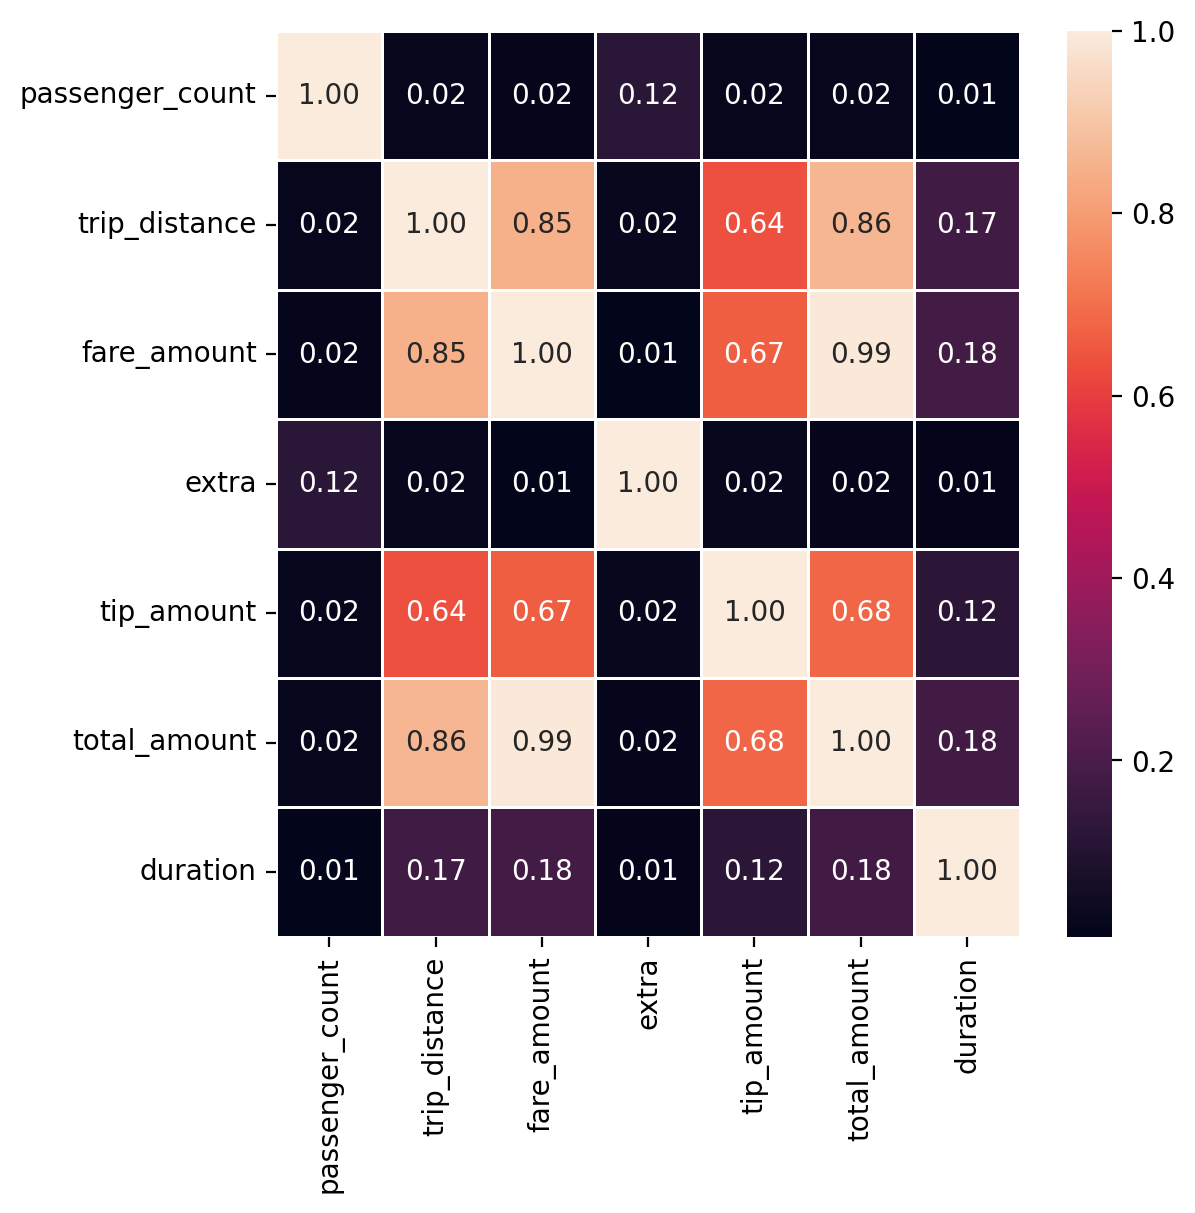

In [14]:
plt.figure(figsize=(6,6), dpi = 200)
sns.heatmap(abs(df.corr()), annot = True, fmt = '.2f', linewidths = 0.5);
# Utilizamos los valores absolutos de correlación a fin de que el gráfico ilustre mejor el paralelo entre variables, independientemente de su signo

La correlación de la columna "fare_amount" con "total_amount" es muy alta, un valor de 0.99 lo que tiene sentido. Entonces quitamos la columna "total_amount", considerando que no aporta ninguna información adicional.

In [15]:
df.drop(columns = ['total_amount'], inplace = True)

Observamos ahora los "outliers". 

In [16]:
print(f'Tamaño del dataset hasta ahora: {len(df)} filas.')

Tamaño del dataset hasta ahora: 1874576 filas.


In [17]:
df.describe()

,passenger_count,trip_distance,fare_amount,extra,tip_amount,duration
count,1.874576e+06,1.874576e+06,1.874576e+06,1.874576e+06,1.874576e+06,1.874576e+06
mean,1.384972e+00,3.096776e+00,1.277085e+01,1.054331e+00,3.022611e+00,8.419176e+02
std,9.792782e-01,4.201687e+00,1.197425e+01,1.246504e+00,2.874279e+00,2.612537e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.080000e+00,6.500000e+00,0.000000e+00,1.760000e+00,3.870000e+02
50%,1.000000e+00,1.760000e+00,9.000000e+00,5.000000e-01,2.360000e+00,6.120000e+02
75%,1.000000e+00,3.080000e+00,1.350000e+01,2.500000e+00,3.320000e+00,9.610000e+02
max,9.000000e+00,6.510000e+02,7.200000e+02,1.400000e+01,8.888800e+02,8.639400e+04


De los datos anteriores observamos que los viajes se hacen en una media de 842 segundos, con un costo de casi 13 dólares y distancia de 4 millas. Pero también podemos ver que las medias calculadas son considerablemente diferentes de las medianas. Esto nos indica la presencia de outliers. 

Con respecto a los viajes, podemos ver que hay valores de distancia o duración en cero. También valores de costo total inferior a 1 dólar (algo imposible). Observamos también valores demasiado elevados que posiblemente se traten de errores o al menos pueden considerarse como outliers.
Consideramos, por lo tanto, filtrar los datos que de desvian "Delta" de la media, donde "Delta" es la diferencia interquartile "Q3-Q1". Consideramos también quitar con respecto a 1.5 desvíos standard de la media. Comparemos los dos casos:

In [18]:
def myfilterQ(column):
    """ Devuelve los valores entre Q1 y Q3 de la columna dada"""
    Qs=column.quantile(q=[0.25,0.75])
    Q3_Q1_diff=Qs.iloc[1]-Qs.iloc[0]
    bottom=column.mean()-Q3_Q1_diff
    up=column.mean()+Q3_Q1_diff
    #print(up,bottom)
    return (column > bottom) & (column < up)

def myfilterS(column):
    """ Devuelve los valores entre 1.5 desvíos std de la media"""
    desvio = column.std()
    media = column.mean()
    
    bottom= media - desvio * 1.5
    up= media + desvio * 1.5
    #print(up,bottom)
    return (column > bottom) & (column < up)


A continuación, vamos a hacer un análisis gráfico de las columnas para intentar determinar qué metodo de eliminación de outliers es conveniente utilizar. 

Las alternativas son:

    1- Eliminar todos los datos que se encuentran fuera del segundo y tercer cuartil
    2- Eliminar todos los datos que se encuentran fuera de  la media +- 1.5 desviaciones estándar

In [19]:
def plotear():
    
    fig, axs = plt.subplots(3, 3,figsize = (16,16))
    
    sns.histplot(ax=axs[0,0],x=df.duration)
    axs[0, 0].set_title("duration base")
    
    sns.histplot(ax=axs[0,1],x=df.trip_distance)
    axs[0, 1].set_title("trip_distance base")
    
    sns.histplot(ax=axs[0,2],x=df.fare_amount)
    axs[0, 2].set_title("fare_amount base")
    
    sns.histplot(ax=axs[1,0],x=df[myfilterQ(df.duration)]["duration"])
    axs[1, 0].set_title("duration filtro intercuartil Q3 - Q1")
    
    sns.histplot(ax=axs[1,1],x=df[myfilterQ(df.trip_distance)]["trip_distance"])
    axs[1, 1].set_title("trip_distance filtro intercuartil Q3 - Q1")
    
    sns.histplot(ax=axs[1,2],x=df[myfilterQ(df.fare_amount)]["fare_amount"])
    axs[1, 2].set_title("fare_amount filtro intercuartil Q3 - Q1")
    
    sns.histplot(ax=axs[2,0],x=df[myfilterS(df.duration)]["duration"])
    axs[2, 0].set_title("duration filtro 1,5 x DS")
    
    sns.histplot(ax=axs[2,1],x=df[myfilterS(df.trip_distance)]["trip_distance"])
    axs[2, 1].set_title("trip_distance filtro 1,5 x DS")
    
    sns.histplot(ax=axs[2,2],x=df[myfilterS(df.fare_amount)]["fare_amount"])
    axs[2, 2].set_title("fare_amount filtro 1,5 x DS")    
  
    return  plt.show()

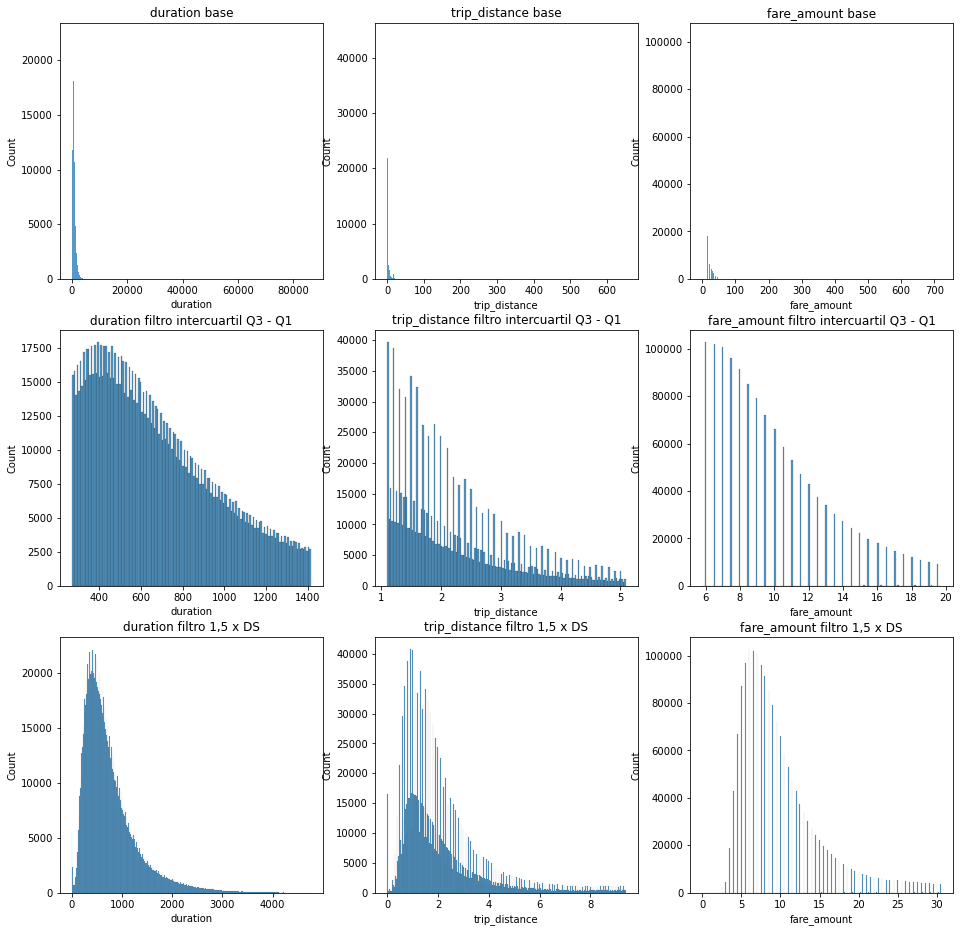

In [20]:
plotear()

Elegimos la primera opción y procedemos.

In [21]:
df=df[myfilterQ(df.duration)]
df=df[myfilterQ(df.trip_distance)]
df=df[myfilterQ(df.fare_amount)]

In [22]:
print(f'Tamaño del dataset hasta ahora: {len(df)} filas.')

Tamaño del dataset hasta ahora: 1059830 filas.


In [23]:
df.describe()

,passenger_count,trip_distance,fare_amount,extra,tip_amount,duration
count,1.059830e+06,1.059830e+06,1.059830e+06,1.059830e+06,1.059830e+06,1.059830e+06
mean,1.384869e+00,1.756751e+00,8.735305e+00,1.050633e+00,2.312455e+00,5.955363e+02
std,9.848548e-01,6.381101e-01,2.057810e+00,1.199801e+00,1.441611e+00,1.993706e+02
min,0.000000e+00,8.300000e-01,5.460000e+00,0.000000e+00,0.000000e+00,2.680000e+02
25%,1.000000e+00,1.230000e+00,7.000000e+00,0.000000e+00,1.950000e+00,4.350000e+02
50%,1.000000e+00,1.640000e+00,8.500000e+00,5.000000e-01,2.260000e+00,5.700000e+02
75%,1.000000e+00,2.180000e+00,1.050000e+01,2.500000e+00,2.850000e+00,7.330000e+02
max,6.000000e+00,3.820000e+00,1.325000e+01,1.150000e+01,8.888800e+02,1.406000e+03


Observamos ahora una distribución de los datos mucho mejor, con una media más cercana a la mediana.

# Caso binarino

Como mencionamos en un comienzo, estamos intentando predecir si una persona va a dejar una propina por encima de la media. Para esto creamos una nueva columna "perc_tip" que contiene el porcentaje de propina dado por el pasajero

In [24]:
df["tip_amount"]

1          4.00
2          1.76
8          2.25
13         3.06
14         2.26
           ... 
2392417    2.05
2392418    3.40
2392419    2.56
2392425    2.95
2392426    2.26
Name: tip_amount, Length: 1059830, dtype: float64

In [25]:
df['perc_tip'] = 100 * df.tip_amount / df.fare_amount
df.perc_tip.describe()

count    1.059830e+06
mean     2.704531e+01
std      1.819515e+01
min      0.000000e+00
25%      2.294737e+01
50%      2.776471e+01
75%      3.146667e+01
max      1.269829e+04
Name: perc_tip, dtype: float64

Vemos que la media de propinas se ubica en aproximadamente 27%. Vamos considerar este valor como umbral para crear una nueva columna target:

In [26]:
df['target'] = df.perc_tip.apply(lambda x: 0 if x < 27 else 1)

Observamos la proporción de propina baja / alta:

In [27]:
df.target.value_counts(normalize = True)

1    0.567466
0    0.432534
Name: target, dtype: float64

Ahora vamos a utilizar distintos modelos y combinaciones de features. Debido al gran tamaño del dataset y para optimizar los cálculos vamos a utilizar una muestra conteniendo el 25% de los datos del dataset para los modelos computacionamente caros (GridSearch, por ejemplo):

In [28]:
df_sample = df.sample(frac = 0.25, random_state = 55)

## Análisis modelando con Naive Bayes

Probamos con todas las columnas primero

In [29]:
df_dum=pd.get_dummies(df)

In [30]:
X=df_dum.drop(columns=['tip_amount','target','perc_tip'])
y=df_dum.target

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=55)

In [32]:
NBclf = GaussianNB()
NBclf.fit(X_train, y_train)

NBclf.score(X_test, y_test)

0.5780199125899199

In [33]:
y_pred = NBclf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.61      0.07      0.13    114809
           1       0.58      0.97      0.72    150149

    accuracy                           0.58    264958
   macro avg       0.59      0.52      0.42    264958
weighted avg       0.59      0.58      0.46    264958



Como (los dummies de) las categóricas no se ajustarían a un modelo Naive Bayes Gaussiano las dropeamos para ver cómo queda sin esas features

In [34]:
X=df.drop(columns=["PULocationID", "DOLocationID",'tip_amount','target','perc_tip'])
y=df.target

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=55)

In [36]:
NBclf = GaussianNB()
NBclf.fit(X_train, y_train)

NBclf.score(X_test, y_test)

0.7012318933566829

In [37]:
y_pred = NBclf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.69      0.57      0.62    114809
           1       0.71      0.80      0.75    150149

    accuracy                           0.70    264958
   macro avg       0.70      0.69      0.69    264958
weighted avg       0.70      0.70      0.70    264958



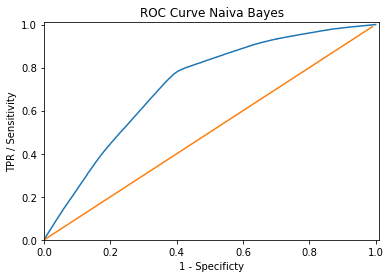

AUC= 0.7205428751093662


In [38]:
y_pred_proba = NBclf.predict_proba(X_test)
fpr_log,tpr_log,thr_log = roc_curve(y_test, y_pred_proba[:,1])
df_roc_nb = pd.DataFrame(dict(fpr=fpr_log, tpr=tpr_log, thr = thr_log))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve Naiva Bayes')
plt.plot(df_roc_nb['fpr'],df_roc_nb['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show()
print('AUC=', auc(fpr_log, tpr_log))

Los f1-score son 0.75 y 0.62 para los _target_ 1 y 0, respectivamente. No está mal para tomarlo como modelo base y ver cómo responden los datos a una regresión logística y a KNN. La curva ROC se levanta levemente sobre la diagonal. Vamos a compararla con otros modelos.

A continuación realizamos un análisis más exhaustivo de las columnas categóricas, para intenter determinar si hay zonas de comienzo o finalización de viajes que contribuyan a una mayor probabilidad de propinas altas.

In [39]:
data_cat = df[["PULocationID", "DOLocationID", "target"]]

In [40]:
df.loc[df["PULocationID"] == 237 ]["target"].value_counts(normalize = True).index[1]

0

In [41]:
dict_PU = {}
dict_DO = {}

for i in data_cat["PULocationID"].unique():
    try:
        dict_PU[i] = data_cat.loc[df["PULocationID"] == i]["target"].value_counts(normalize = True)[1]
    except KeyError:
        dict_PU[i] = 0
        
for i in data_cat["DOLocationID"].unique():
    try:
        dict_DO[i] = data_cat.loc[df["DOLocationID"] == i]["target"].value_counts(normalize = True)[1]
    except KeyError:
        dict_DO[i] = 0

In [42]:
dict_PU = pd.Series(dict_PU)
dict_DO = pd.Series(dict_DO)

In [43]:
# lugares de subida donde hay 100% que den propina arriba del promedio
list(dict_PU[(dict_PU == 1)].index)

[174, 241, 203, 38, 147, 126, 160, 22, 32, 182]

In [44]:
# lugares de subida donde hay 0% que den propina arriba del promedio (tacaños!)
dict_PU[(dict_PU == 0)].index

Int64Index([ 83, 210,  34, 136,  18, 258,  54, 154,  67, 130, 173, 259,  51,
             63,  92,  72,  47, 108, 205, 184, 167, 165, 216, 235, 248, 185,
             14,  85, 219, 131,  98,  20,  39,  56, 200,  53],
           dtype='int64')

In [45]:
# lugares de bajada donde hay 100% que den propina arriba del promedio
dict_DO[(dict_DO == 1)].index

Int64Index([254, 111, 53, 128, 38, 212, 105, 108, 102], dtype='int64')

In [46]:
# lugares de bajada donde hay 0% que den propina arriba del promedio
dict_DO[(dict_DO == 0)].index

Int64Index([ 47,  56, 210,  57, 185, 123, 253, 130,   3, 155, 221, 135, 192,
            139, 207, 157, 131, 198, 222,  35, 160, 215, 214, 149,  18, 147,
             51, 165,  60, 258, 250,  21, 205, 242,  98, 200,  39,  55, 134,
            178,  16, 197],
           dtype='int64')

## Análisis por Regresión Logistica

Para considerar todas las columnas, primero debemos transformar las variables categóricas en variables de tipo dummie.

In [47]:
df_dum = pd.get_dummies(df_sample, drop_first = True)

In [48]:
X = df_dum.drop(columns = ['tip_amount','target','perc_tip'])
y = df_dum.target

In [49]:
X.columns

Index(['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'duration',
       'PULocationID_2', 'PULocationID_3', 'PULocationID_4', 'PULocationID_5',
       'PULocationID_6',
       ...
       'DOLocationID_256', 'DOLocationID_257', 'DOLocationID_258',
       'DOLocationID_259', 'DOLocationID_260', 'DOLocationID_261',
       'DOLocationID_262', 'DOLocationID_263', 'DOLocationID_264',
       'DOLocationID_265'],
      dtype='object', length=515)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 55)

In [51]:
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [52]:
# Averiguando las dimensiones
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((198718, 515), (66240, 515), (198718,), (66240,))

In [53]:
c_values=[]
for C in [10000,1000,100,10,1]:
    logreg = LogisticRegression(C=C)
    logreg.fit(X_train_scaled, y_train)
    y_pred = logreg.predict(X_test_scaled)
    c_values.append(f1_score(y_test,y_pred))

In [54]:
c_values

[0.7552309118700979,
 0.7552309118700979,
 0.7552309118700979,
 0.7552309118700979,
 0.7552715654952078]

De acuerdo a los resultados, no parece que estemos en presencia de overfit, tenemos las mismas predicciones para cualquier valor de C. 

Considerando el dataframe completo:

In [55]:
df_dum = pd.get_dummies(df, drop_first = True)

In [56]:
X = df_dum.drop(columns = ['tip_amount','target','perc_tip'])
y = df_dum.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=55)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [57]:
logreg = LogisticRegression(C = 1)
logreg.fit(X_train_scaled,y_train)
y_pred = logreg.predict(X_test_scaled)

In [58]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.69      0.57      0.63    114809
           1       0.71      0.81      0.76    150149

    accuracy                           0.71    264958
   macro avg       0.70      0.69      0.69    264958
weighted avg       0.70      0.71      0.70    264958



Una predicción aceptable, y un poco mejor que la de Naive Bayes. Esto podría ser esperado, dado que las features que tenemos no son tan independientes entre sí, como por ejemplo "duration", "fare_amount" y "trip_distance".

Miramos ahora la importancia de las _features_ según el código publicado en https://sefiks.com/2021/01/06/feature-importance-in-logistic-regression/ .

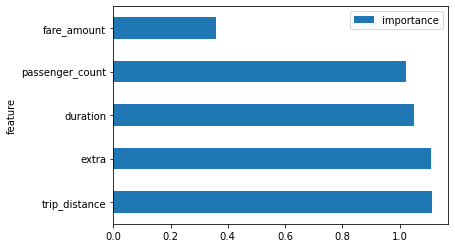

In [59]:
feature_names = ['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'duration']

feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = pow(math.e, logreg.coef_[0][0:5])
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)

ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()

Como era de esperarse, la variable más relevante para la determinación del porcentaje de propina es el precio del viaje, _fare_amount_.

C:\Users\fabionr\anaconda3\envs\TF\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


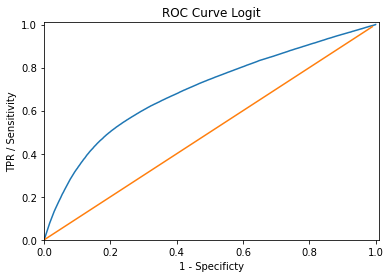

AUC= 0.692455466480385


In [60]:
y_pred_proba = logreg.predict_proba(X_test)
fpr_log,tpr_log,thr_log = roc_curve(y_test, y_pred_proba[:,1], pos_label = 0)
df_roc_logreg = pd.DataFrame(dict(fpr=fpr_log, tpr=tpr_log, thr = thr_log))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve Logit')
plt.plot(df_roc_logreg['fpr'],df_roc_logreg['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show()
print('AUC=', auc(fpr_log, tpr_log))

Utilizamos ahora Statmodels para intentar determinar si las variables numéricas son estadísticamente significativas para el modelo.

In [61]:
X=df.drop(columns=['tip_amount','target','perc_tip', 'PULocationID', 'PULocationID'])

y=df.target

scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

mod = sm.Logit(y, X_scaled)

res = mod.fit(maxiter = 300, method='newton')

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.611307
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:              1059830
Model:                          Logit   Df Residuals:                  1059824
Method:                           MLE   Df Model:                            5
Date:                Mon, 06 Jun 2022   Pseudo R-squ.:                  0.1063
Time:                        21:25:49   Log-Likelihood:            -6.4788e+05
converged:                       True   LL-Null:                   -7.2494e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0258      0.002     12.099      0.000       0.022       0.030
x2             0.1474      0.

El resultado nos indica que al menos las variables analizadas son significativas para nuestro modelo.

## Análisis por KNN - Sin variables categóricas

Ignorando las columnas categóricas y las relacionadas con la propina, intentamos predicir la cantidad de propina usando KNN y GridSearch. Tal como venimos haciendo, vamos a utilizar una muestra del dataframe para reducir los tiempos de procesamiento.

In [62]:
X = df_sample.drop(columns = ['tip_amount','target','perc_tip','PULocationID','DOLocationID'])
y = df_sample.target

In [63]:
X.columns

Index(['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'duration'], dtype='object')

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=55)

In [65]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [66]:
# Avergiguando las dimensiones
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((198718, 5), (66240, 5), (198718,), (66240,))

In [67]:
knn = KNeighborsClassifier()

In [68]:
k_range = list(range(4,61,4))
weight_options = ['uniform', 'distance']

In [69]:
param_grid = dict(n_neighbors = k_range, weights = weight_options)
folds = StratifiedKFold(n_splits = 5, random_state = 55, shuffle = True)

In [70]:
grid = GridSearchCV(knn, param_grid, cv = folds, scoring = 'f1')
grid.fit(X_train_scaled,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=55, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [4, 8, 12, 16, 20, 24, 28, 32, 36, 40,
                                         44, 48, 52, 56, 60],
                         'weights': ['uniform', 'distance']},
             scoring='f1')

El mejor modelo tiene los siguientes hiperparámetros:

In [71]:
print(f'Mejor estimador: {grid.best_estimator_}')
print(f'Su F1: {grid.best_score_}')
print(f'Sus parámetros: {grid.best_params_}')

Mejor estimador: KNeighborsClassifier(n_neighbors=52)
Su F1: 0.797575054594223
Sus parámetros: {'n_neighbors': 52, 'weights': 'uniform'}


In [72]:
X = df.drop(columns = ['tip_amount','target','perc_tip','PULocationID','DOLocationID'])
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 55)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors = 52, weights = 'uniform').fit(X_train_scaled, y_train)

In [73]:
y_pred = knn.predict(X_test_scaled)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.53      0.64    114809
           1       0.72      0.91      0.80    150149

    accuracy                           0.74    264958
   macro avg       0.77      0.72      0.72    264958
weighted avg       0.76      0.74      0.73    264958



Ahora vamos a utilizar los parámetros encontrados a traves de GridSearch para modelar el dataset completo:

<AxesSubplot:>

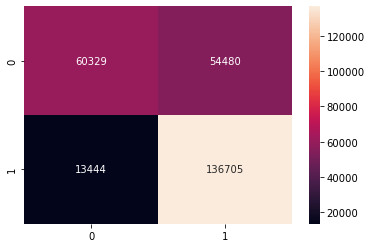

In [74]:
y_pred = knn.predict(X_test_scaled)
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = '2d')

In [75]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.53      0.64    114809
           1       0.72      0.91      0.80    150149

    accuracy                           0.74    264958
   macro avg       0.77      0.72      0.72    264958
weighted avg       0.76      0.74      0.73    264958



Una performance buena, un poco mejor que los otros dos métodos. Es importante notar la importancia de la búsqueda por grid. El peor valor de F1-score encontrado fue de 0.66, mientras que el mejor fue de 0.80, una diferencia muy significativa.

In [76]:
min=np.min(pd.DataFrame(grid.cv_results_).mean_test_score)
max=np.max(pd.DataFrame(grid.cv_results_).mean_test_score)
print(f'Valores de F1 minimo / maximo encontrado: {np.round(min,2)}/{np.round(max,2)}')

Valores de F1 minimo / maximo encontrado: 0.66/0.8


# Multicategórico

Cuando pensamos en crear más categorías, la primera y más importante pregunta es cuántas, y por qué. Para tener una sugerencia de la cantidad de grupos y cómo se diferencian entre sí, vamos a hacer una búsqueda no supervisada, ignorando la variable _target_, y enfocando en las features más importantes.

In [77]:
X=df_sample[['passenger_count', 'trip_distance', 'fare_amount', 'duration']]

In [78]:
X_scaled=scaler.fit_transform(X)

In [79]:
k_range=range(2,9)
k_val=[]
for k in k_range:
    km=KMeans(n_clusters=k,n_init=25,random_state=55)
    km.fit(X_scaled)
    k_val.append(km.inertia_)

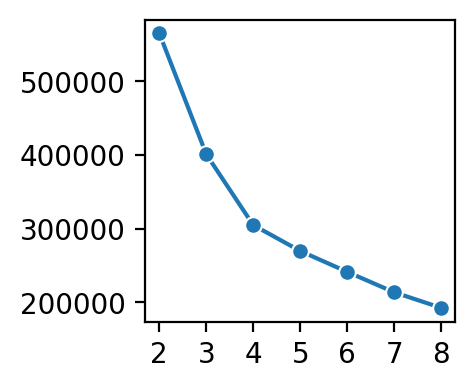

In [80]:
plt.figure(figsize=(2,2),dpi=200)
sns.lineplot(x=k_range,y=k_val,marker='o',legend=False);
plt.xticks([2,3,4,5,6,7,8]);

El codo está en 4. Considerando el dataframe completo: 

In [81]:
X=df[['passenger_count', 'trip_distance', 'fare_amount', 'duration']]

X_scaled=scaler.fit_transform(X)

km=KMeans(n_clusters=4,n_init=25,random_state=55)
km.fit(X_scaled)

KMeans(n_clusters=4, n_init=25, random_state=55)

Salvando la información de cada grupo en una nueva columna.

In [82]:
df['KMeans_labels']=km.labels_

Analizando la correlación de la nueva columna con las otras.

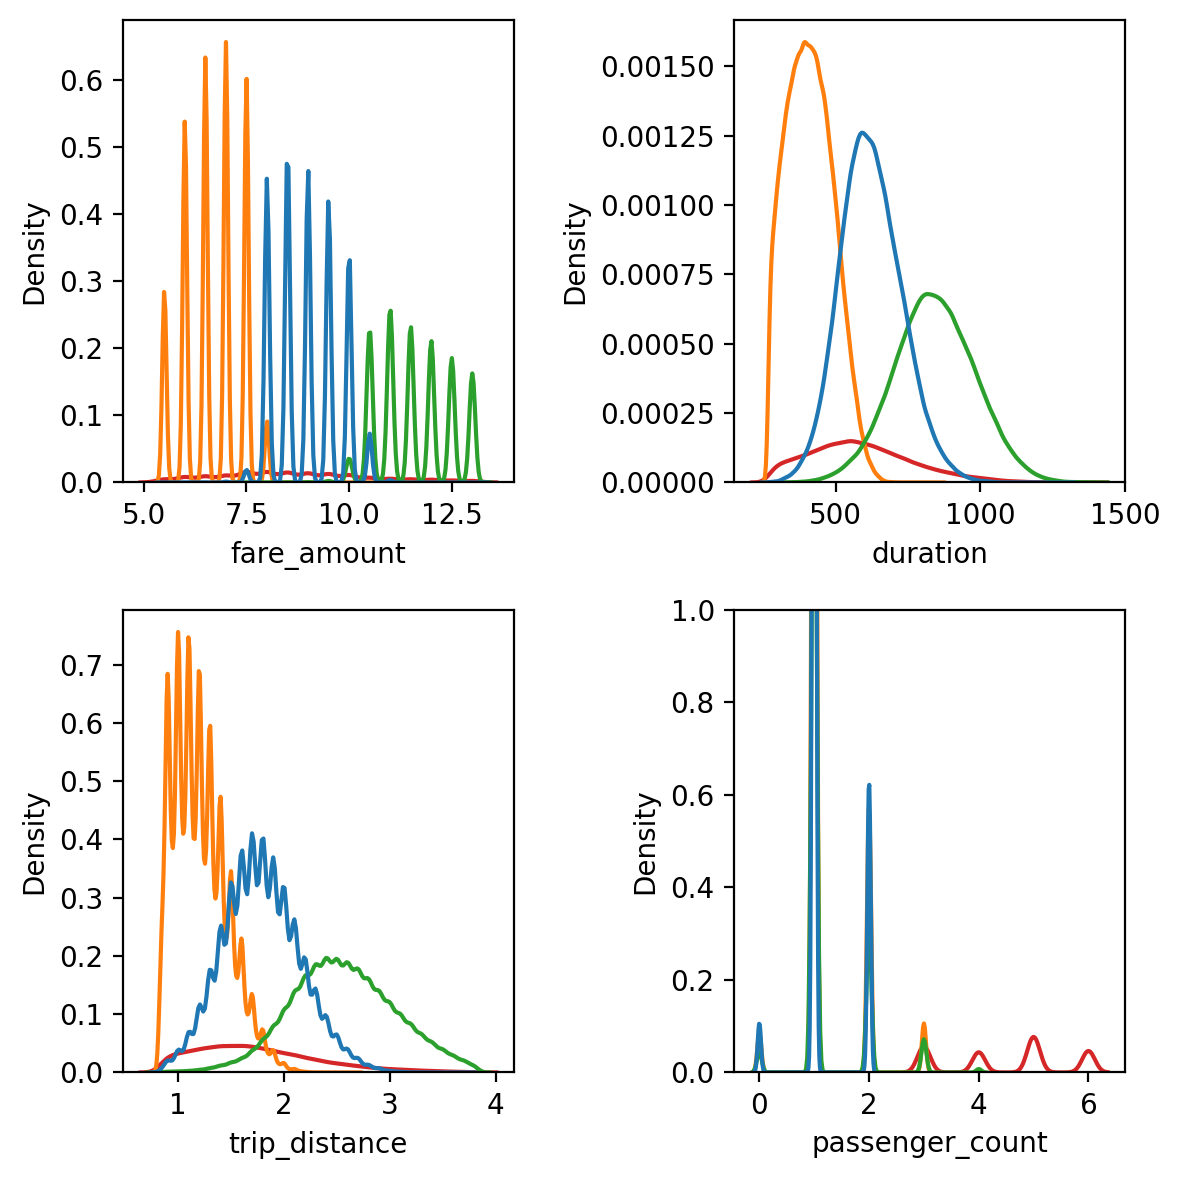

In [83]:
# Color de cada grupo
palette = {0: 'tab:blue',1: 'tab:green',2: 'tab:orange',3: 'tab:red'}

# Subplot
fig, axs = plt.subplots(2, 2,figsize=(6,6),dpi=200)
sns.kdeplot(data=df,x='fare_amount',hue='KMeans_labels',palette=palette,ax=axs[0,0]);
sns.kdeplot(data=df,x='duration',hue='KMeans_labels',palette=palette,ax=axs[0,1]);
sns.kdeplot(data=df,x='trip_distance',hue='KMeans_labels',palette=palette,ax=axs[1,0]);
sns.kdeplot(data=df,x='passenger_count',hue='KMeans_labels',palette=palette,ax=axs[1,1]).set_ylim(0,1);
axs[0,0].get_legend().remove(),axs[0,1].get_legend().remove()
axs[1,0].get_legend().remove(),axs[1,1].get_legend().remove()
fig.tight_layout()

Con el gráfico de arriba, se pueden entender los 4 grupos creados. Los grupos de 0 a 2 (azul, verde y naranja) están bien separados en bajo, medio y alto valores para el costo, duracción y distancia recorrida del viaje. El grupo 3 (rojo) es distinto en el número de pasajeros, enfocando solo en un grupo de 3 pasajeros o más.

Miramos ahora si hay una relación clara entre los 4 grupos y la cantidad de propina dejada.

In [84]:
filtered_df=df[df.perc_tip < 100]

(-5.0, 65.0)

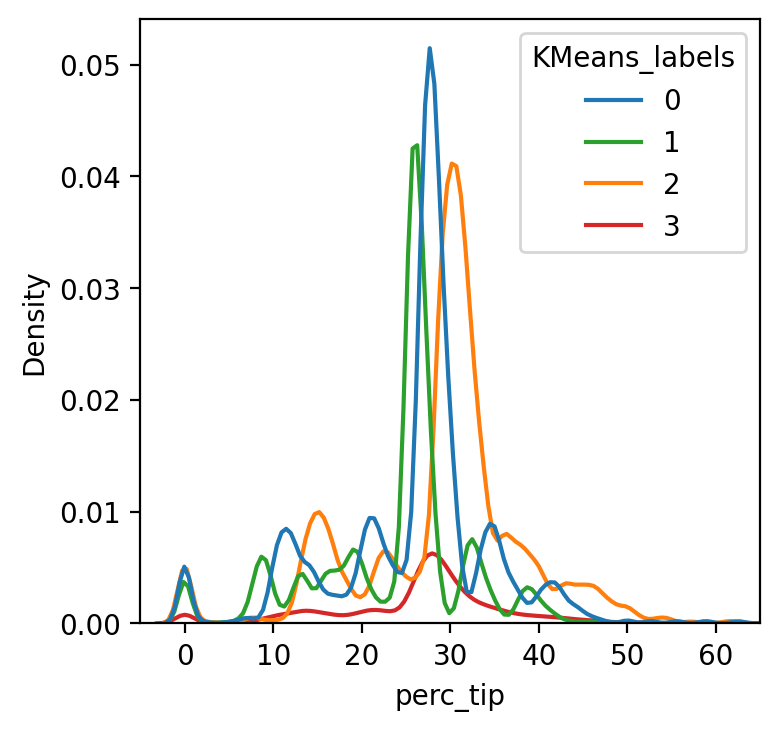

In [85]:
# Color de cada grupo
palette = {0: 'tab:blue',1: 'tab:green',2: 'tab:orange',3: 'tab:red'}

# Subplot
plt.figure(figsize=(4,4),dpi=200)
sns.kdeplot(data=filtered_df,x='perc_tip',hue='KMeans_labels',palette=palette);
plt.xlim(-5,65)

Con respecto al porcentaje de propina dejada, se ve que 3 grupos tienen una cierta separación, o sea, el porcentaje de propina que se deja parece tener una pequeña conexión con el precio total del viaje. Así que puede ser interesante una separación en 3 grupos, que pagan mala/media/buena propina.

In [86]:
df2=df[['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'duration', 'perc_tip']]

In [87]:
df2.quantile(0.3333)[5],df2.quantile(0.6667)[5]

(25.90909090909091, 30.11764705882353)

In [88]:
def multi_filter(x):
    if x < 25.9:
        return 0
    if (x >= 25.9) & (x < 30.1):
        return 1
    if x >= 30.1:
        return 2

df['target2']=df['perc_tip'].apply(multi_filter)

In [89]:
df.target2.value_counts()

1    355163
2    354098
0    350569
Name: target2, dtype: int64

In [90]:
X=df[['passenger_count', 'trip_distance','fare_amount', 'extra','duration']]
y=df.target2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=55)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

NBclf = GaussianNB()
NBclf.fit(X_train_scaled, y_train)
acc=NBclf.score(X_test_scaled, y_test)
print(f'NB accuracy: {np.round(acc,2)}')

NB accuracy: 0.52


In [91]:
logreg = LogisticRegression()
logreg.fit(X_train_scaled,y_train)
acc=logreg.score(X_test_scaled,y_test)
print(f'Log. reg. accuracy: {np.round(acc,2)}')

Log. reg. accuracy: 0.48


Una _accuracy_ razonable, dado que es una situación más compleja de modelar.

# Conclusiones

En este proyecto usamos 3 modelos de classificación para modelar el porcentaje de propina dejado por los pasajeros de taxi en Nueva York en enero de 2022. Para cada modelo, optimizamos los hiperparámetros para llegar a los mejores _scores_. Vimos que lost tres modelos obtivieran una _performance_ muy similar. KNN resultó ser el más costoso a nivel computacional.

El modelo puede extenderse a un target multicategórico, de acuerdo a los resultados obtenidos con unsupervised learning. Luego del modelado, observamos que los _scores_ obtenidos son inferiores al caso binario. Pero son razonables, teniendo en cuenta que la opción multicategórica es un problema más complejo.